In [1]:
import datetime
import os

import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
import plotly.graph_objs as go
init_notebook_mode(connected=True)


print(os.getcwd())

/Users/DayTightChunks/Documents/PhD/Models/phd-model-visuals


In [2]:
gen = "Gen3"
path = '../phd-model-process/'

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import scipy as sp
import scipy.stats as st

from helpers_pd import *

# Plotting
import seaborn as sns
sns.set()
# import seaborn as sns; sns.set(style="ticks", color_codes=True)
# sns.set(style="darkgrid")
import matplotlib.pyplot as plt
# plt.style.use('seaborn-white')

In [3]:
palette = ["#F44336", '#673AB7', '#3F51B5', '#009688', '#FF9800', '#4CAF50', '#03A9F4']
# red, purple, indigo, teal-green, orange, green, light-blue

# Extracting observed Conc.

## Define transect

In [4]:
comp = pd.read_table(path + 'observations/conc_comp_cal.tss')
comp.head()

,Jdays,Transect,IDcal,ug.g,ug.g.SD
0,188,N,N-188,1.854481,0.176483
1,188,S,S-188,7.623602,0.110718
2,188,V,V-188,1.707151,0.038673
3,197,N,N-197,5.628515,0.058313
4,197,S,S-197,3.686628,0.310806


In [5]:
det = pd.read_table(path + 'observations/conc_det_cal.tss')
det.head()

,Jdays,Transect,IDcal,ug.g
0,181,N,N1-181,0.071209
1,181,N,N2-181,4.710027
2,181,N,N3-181,1.486026
3,181,N,N4-181,0.023645
4,181,N,N5-181,0.158614


In [6]:
obs = pd.concat([comp, det])
obs.head()

,IDcal,Jdays,Transect,ug.g,ug.g.SD
0,N-188,188,N,1.854481,0.176483
1,S-188,188,S,7.623602,0.110718
2,V-188,188,V,1.707151,0.038673
3,N-197,197,N,5.628515,0.058313
4,S-197,197,S,3.686628,0.310806


# Selecting indexes

In [7]:
df = get_data(gen=gen)

In [8]:
# 'LHS_s2fix7/10/' in list(df.index)
# list(df)

In [9]:
df['k_d'] = df.loc[:, 'k_oc'] * df.loc[:,'f_oc']
# Combined outlet and transects KGE Concentrations and d13C
df['KGE-SM'] = (df.loc[:, 'KGE-CONC_out'] + df.loc[:, 'KGE-CONC-tra'])/2.0  
df['KGE-d13C'] = (df.loc[:, 'KGE-d13C_out'] + df.loc[:, 'KGE-d13C-tra'])/2.0

cst = 0.1
df['Constraint'] = df.apply(WithIsoKGE, args=(cst,), axis=1)

In [10]:
print("Maximum Q")
print(df['KGE-Q_out'].max(), df['NSE-Q_out'].max()) 
print("Maximum Conc.")
print(df['KGE-CONC-tra'].max(), df['KGE-CONC_out'].max(), df['KGE-SM'].max()) 
print("Maximum d13C")
print(df['KGE-d13C-tra'].max(), df['KGE-d13C_out'].max(), df['KGE-d13C'].max()) 

Maximum Q
(0.7842439112230416, 0.5637710843308736)
Maximum Conc.
(0.8064547629007521, 0.4150148273020837, 0.5757629457531775)
Maximum d13C
(0.8760485369317733, 0.5505380490963844, 0.7105583194233951)


In [11]:
dfs = df[['Model',
#           'dt_50_ref',
#           'k_d',
#           'epsilon_iso',
          'KGE-SM', 'KGE-d13C', 'Constraint'
          ]]

In [12]:
# Filter
ff = dfs.loc[(dfs['KGE-SM'] > 0.10)] # Try 25 with more data points
ff_c = ff.loc[(ff['KGE-d13C'] > 0.0)]
print(len(dfs), len(ff), len(ff_c))
ff.tail()

(1214, 583, 362)


,Model,KGE-SM,KGE-d13C,Constraint
LHS_s2var28/67/,var,0.100759,0.388430,WC
LHS_s2var28/69/,var,0.272998,0.212619,WC
LHS_s2var28/70/,var,0.103463,-0.343157,NC
LHS_s2var28/72/,var,0.127631,-0.009998,NC
LHS_s2var28/9/,var,0.246686,0.143643,WC


In [13]:
nc = ff.index[(ff['Constraint'] == 'NC')].tolist() #[0]
wc = ff.index[(ff['Constraint'] == 'WC')].tolist() #[0]
print(len(nc), len(wc))

# nc = nc[0:len(wc)]

print(len(nc), len(wc))

(257, 326)
(257, 326)


## Update path for Generation

In [14]:
path += gen + '/'

# Cumulative applied mass (grams)

All data frames have this time series, and does not change

In [15]:
app = pd.read_table(path + nc[0] + "resM_accAPP.tss", 
                   skiprows=4, delim_whitespace=True,
                                names=['Jdays', 'app'],
                                header=None)
# time = app['Jdays']
app['Capp'] = app['app'].cumsum()
# app.head()

# Extracting time series

In [16]:
def get_sets(name_list, filename, vname):
    sets = []
    for i in range(len(name_list)):
        # Define variable name
        series_name = vname + name_list[i][3:] # Variable + set's name
        # Get sim TSS
        sim = pd.read_table(path + name_list[i] + filename, 
                       skiprows=4, delim_whitespace=True,
                                    names=['Jdays', series_name],
                                    header=None
                      )
        sim = sim[['Jdays', series_name]]
        sets.append(sim)
    df = reduce(lambda left, right: pd.merge(left,right,on='Jdays'), sets)
    return df

# Confidence interval calc.

In [17]:
def concat(row, plot):
    return plot.capitalize() + '-' + str(int(row['Jdays']))

In [18]:
def get_stats_df(df, loc, level, cst):
    n = len(np.array(df.iloc[0,1:]))
    df['mean'] = df.iloc[:,1:n+1].mean(axis=1)
    df['min'] = df.iloc[:,1:n+1].min(axis=1)
    df['max'] = df.iloc[:,1:n+1].max(axis=1)
    df['sem'] = df.iloc[:,1:n+1].sem(axis=1)
    df['sd'] = df.iloc[:,1:n+1].std(axis=1)
    df['high'] = df['mean'] + 2.*df['sd']
    df['low'] = df['mean'] - 2.*df['sd']
#     df['high'] = df.apply(get_ci, args=(n, 0.95, True), axis=1)
#     df['low'] = df.apply(get_ci, args=(n, 0.95, False), axis=1)
    df['low'] = df.apply(check_negative, axis=1)
    df['Trans'] = loc
    df['Area'] = loc[0]
    df['Level'] = level  # Composite or Detailed, 
    df['IDcal'] = df.apply (lambda row: concat(row, loc), axis=1)
    df['Type'] = df.apply(lambda row: ModelType(row, cst),axis=1)
    return df[['Jdays', 'mean', 'high', 'low', 'max', 'min', 'Trans', 'Area', 'Level', 'IDcal', 'Type']]

In [19]:
comp = ['nor', 'val', 'sou']

det = ['n1', 'n2', 'n4', 'n7', 'n8',
       'v4', 'v7', 'v8', 'v9', 'v10',
       's11', 's12', 's13']

levels = ["Composite", "Detailed"]
label = ['No d13C', 'With d13C']

# constrained sets
wc_stat = []
for level in levels:
    if level == "Composite":
        smp = comp
        end = 1
    else:
        smp = det
        end = None
        
    for i in range(len(smp)):
        filename = "resM_" + smp[i] + 'CONC_real.tss'
        sets = get_sets(wc, filename, smp[i]) # Returns sets merged
        df = get_stats_df(sets, smp[i][0:end].capitalize(), level, label[1]) # Analyzed sets, WC!

        wc_stat.append(df) # nc_stat 

wc_all = pd.concat(wc_stat)  


In [20]:
wc_all.tail(4)

,Jdays,mean,high,low,max,min,Trans,Area,Level,IDcal,Type
117,283,1.372043,3.010521,0.052237,3.96965,0.052237,S13,S,Detailed,S13-283,With d13C
118,284,1.350795,2.975910,0.052042,3.93852,0.052042,S13,S,Detailed,S13-284,With d13C
119,285,1.329358,2.941871,0.051480,3.91106,0.051480,S13,S,Detailed,S13-285,With d13C
120,286,1.307883,2.906355,0.051246,3.88206,0.051246,S13,S,Detailed,S13-286,With d13C


In [21]:
# wc_all.loc[wc_all['Trans']=='V10']

In [22]:
wc_merged = pd.merge(wc_all, obs, how='outer', on='IDcal')
wc_merged.tail(2)

,Jdays_x,mean,high,low,max,min,Trans,Area,Level,IDcal,Type,Jdays_y,Transect,ug.g,ug.g.SD
1944,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N5-286,NaN,286.0,N,0.045621,NaN
1945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V5-286,NaN,286.0,V,0.026046,NaN


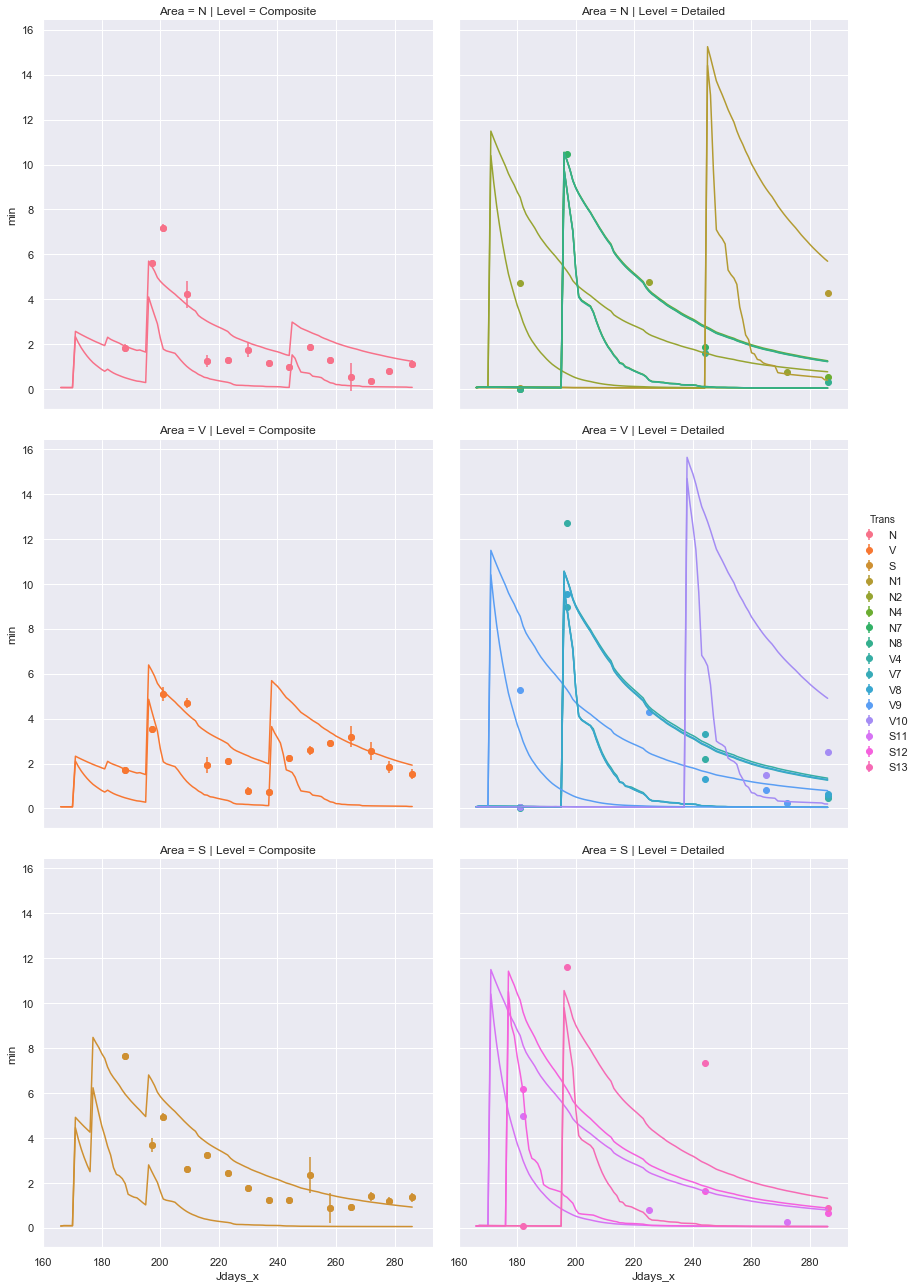

In [23]:
g = sns.FacetGrid(wc_merged, row="Area", col="Level", hue='Trans', height=6)
g.map(plt.scatter, "Jdays_x", "ug.g")
g.map(plt.errorbar, "Jdays_x", "ug.g", "ug.g.SD", marker="o", linestyle='None')
g.map(plt.plot, "Jdays_x", "mean")
g.map(plt.plot, "Jdays_x", "min").add_legend()
# g.map(plt.plot, "Jdays_x", "max", color="r")

1. Second Burger Application, there is no isotope data to make this call!!
2. There is also no isotope data to make an assumption on a second application by Friess in the North and Valley (I did not include one on the South).

## Non-constrained

In [24]:
# non-constrained sets
nc_stat = []
for level in levels:
    if level == "Composite":
        smp = comp
        end = 1
    else:
        smp = det
        end = None
        
    for i in range(len(smp)):
        filename = "resM_" + smp[i] + 'CONC_real.tss'
        sets = get_sets(nc, filename, smp[i]) # Returns sets merged
        df = get_stats_df(sets, smp[i][0:end].capitalize(), level, label[1]) # Analyzed sets, WC!

        nc_stat.append(df) # nc_stat 

nc_all = pd.concat(nc_stat)  

In [25]:
# nc_all.head()
nc_merged = pd.merge(nc_all, obs, how='outer', on='IDcal')

In [26]:
nc_merged.head()

,Jdays_x,mean,high,low,max,min,Trans,Area,Level,IDcal,Type,Jdays_y,Transect,ug.g,ug.g.SD
0,166.0,0.075369,0.086764,0.063974,0.075451,0.075226,N,N,Composite,N-166,With d13C,NaN,NaN,NaN,NaN
1,167.0,0.074983,0.086320,0.063646,0.075146,0.074702,N,N,Composite,N-167,With d13C,NaN,NaN,NaN,NaN
2,168.0,0.074663,0.085954,0.063373,0.074905,0.074255,N,N,Composite,N-168,With d13C,NaN,NaN,NaN,NaN
3,169.0,0.074346,0.085591,0.063101,0.074666,0.073819,N,N,Composite,N-169,With d13C,NaN,NaN,NaN,NaN
4,170.0,0.074032,0.085233,0.062830,0.074427,0.073394,N,N,Composite,N-170,With d13C,NaN,NaN,NaN,NaN


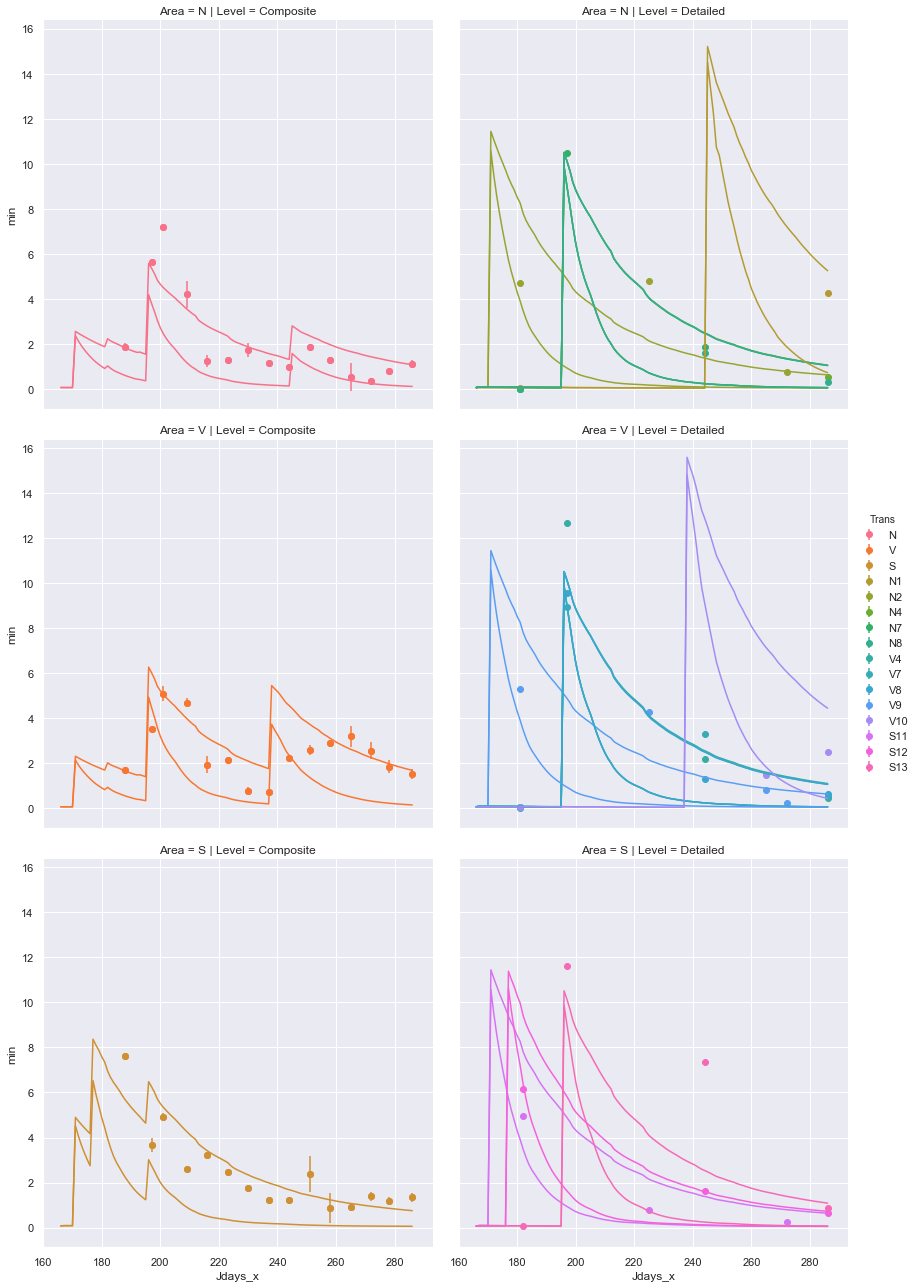

In [27]:
g = sns.FacetGrid(nc_merged, row="Area", col="Level", hue='Trans', height=6)
g.map(plt.scatter, "Jdays_x", "ug.g")
g.map(plt.errorbar, "Jdays_x", "ug.g", "ug.g.SD", marker="o", linestyle='None')
g.map(plt.plot, "Jdays_x", "mean")
g.map(plt.plot, "Jdays_x", "min").add_legend()